Original data available at:
https://www.kaggle.com/kaushik3497/imdb-sentiment-analysis

In [1]:
%matplotlib inline
import sys
sys.path.append('../data/')

In [245]:
from typing import Tuple, Sequence, Dict, Callable, Any, List, Pattern, Union, Iterable, overload
import nltk
from concurrent.futures import ProcessPoolExecutor, as_completed
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer, PunktSentenceTokenizer
from nltk.tag import DefaultTagger, UnigramTagger, BigramTagger
from nltk.corpus import brown
import re
from pathlib import Path
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
import csv
import random
import numpy as np
import spacy
import toolz as tz
from pattern.en import parse
import toolz.curried as tzc
import pandas as pd
import matplotlib.pyplot as plt


import pattern
from pattern.web import plaintext

import bs4

from collections import Counter, OrderedDict

from gensim.models.phrases import Phrases, Phraser
from gensim.models.fasttext import FastText

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pp, feature_extraction
from sklearn import naive_bayes, linear_model, metrics, model_selection, svm, ensemble
from sklearn import pipeline
from functools import partial

In [3]:
# nlp = spacy.load('en')

In [4]:
train_file = Path('../data/labeledTrainData.tsv')
 

In [5]:
f = train_file.open()
records = csv.DictReader(f, delimiter='\t', quoting=csv.QUOTE_NONE)

In [6]:
r = next(records)
r

OrderedDict([('id', '"5814_8"'),
             ('sentiment', '1'),
             ('review',
              '"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it 

In [7]:
# !head ../data/labeledTrainData.tsv

In [8]:
raw_dataset = pd.read_csv(train_file, sep='\t', quoting=csv.QUOTE_NONE) 
# We'll handle quotes manually.

raw_train_dataset, raw_test_dataset = train_test_split(raw_dataset, test_size=0.1)

In [9]:
# raw_train_dataset, raw_devtest_dataset = train_test_split(raw_observable_dataset, test_size=0.1)

In [10]:
def strip_quotes_and_ids(dataset):
    no_id_dataset = dataset.drop('id', 'columns')
    no_id_dataset['review'] = no_id_dataset['review'].str.strip('\""')
    return no_id_dataset



In [11]:
dataset = strip_quotes_and_ids(raw_train_dataset)
dataset.head(10)

,sentiment,review
23705,1,"This movie is a ripoff of James Cain's novel, ..."
18761,0,Trot out every stereotype and misrepresentatio...
20263,1,Good story and excellent animation. The influe...
15504,1,I saw this jolly little film at age 10/11 in 1...
7990,1,The film as entertainment is very good and Jim...
24626,1,"CAT SOUP has two \""Hello Kitty\""-type kittens ..."
6342,0,Saying this movie is extremely hard to follow ...
11738,0,the IMDb guidelines state that you have to dec...
24617,1,I think Charlotte Gainsbourg is one of the bes...
4558,0,To be honest I knew what to expect before I wa...


In [12]:
dataset.groupby('sentiment').count()

,review
sentiment,
0,11243
1,11257


The dataset is well balanced

count    22500.000000
mean      1326.577556
std       1005.272169
min         52.000000
25%        702.000000
50%        979.000000
75%       1619.000000
max      13708.000000
Name: review, dtype: float64


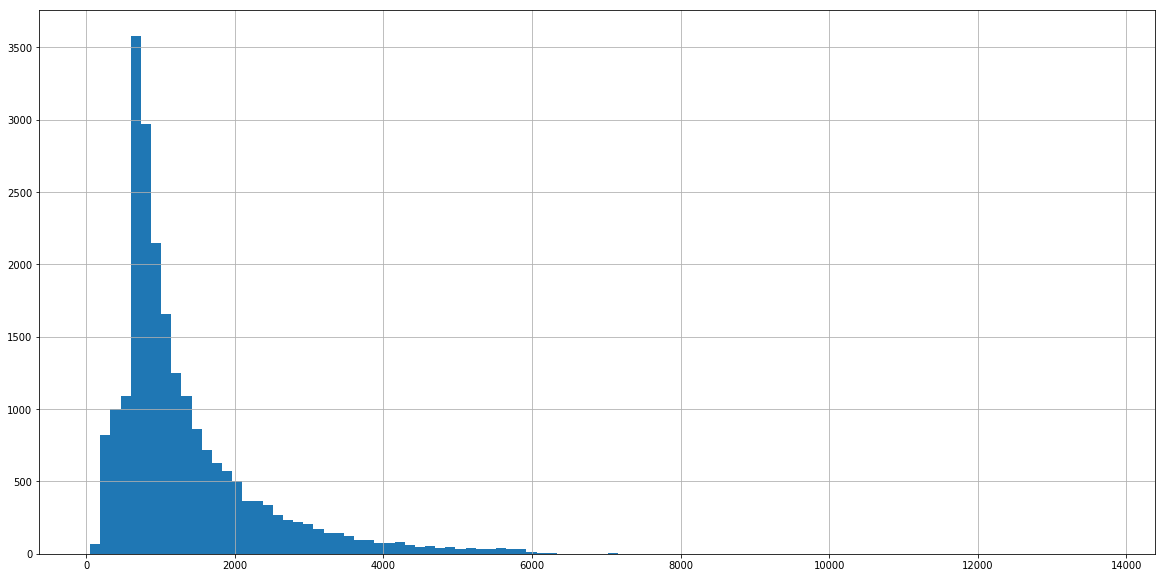

In [13]:
review_lengths = dataset['review'].map(len)
fig = plt.figure(figsize=(20, 10))
review_lengths.hist(bins=100);
print(review_lengths.describe())

In [14]:
sample = dataset.sample(1)
print(f'sentiment: {sample.values[0, 0]}')
review = sample.values[0, 1]
print(review)

sentiment: 1
Goebbels motivation in backing down was not explored. In the aftermath of Stalingrad the Reich had decided to go for 'total war'. This is referred to in the film. Part of this was to use women in the war effort, which Germany had not previously done to any great extent. An SS massacre of women would have faced Goebbels with a public relations disaster of massive proportion. His preference was to make the problem go away as quietly as possible, on the basis that the Jewish men could always be rounded up later. I understand the majority survived the war.<br /><br />His other problem was that the 'Red' Berlin had never been very enthusiastically behind the Nazi cause and had to be handled cautiously. Again a massacre of women could have cost the Nazis what mediocre level of support they had in their capital city.<br /><br />It was interesting that the majority of SS uniforms showed patches which indicated that the men wearing them were not of German nationality, but were from

In [15]:
# bs4.BeautifulSoup(sample.values[0, 1]).get_text()

Notes:
* need to remove escaped quotes.
* need to remove html tags
* possibly parentheses. [ (][)}{ ]

In [16]:
import requests
def get_raw_english_contractions():
    resp = requests.get('https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions')
    soup = bs4.BeautifulSoup(resp.text)
    table = soup.find('table', attrs={'class': 'wikitable'})
    table.find('tbody')
    data = []
    for row in table.find_all('tr'):
        cols = row.find_all('td')
        data.append([
            c.get_text()\
                .strip()\
                .replace(r'\[.+\]', '')
            for c in cols
        ])
    return data

def get_curated_english_contractions():
    with open('../data/curated_contractions.csv') as f:
        reader = csv.reader(f)
        contractions = [row for row in reader]
    return contractions
        

In [17]:
contraction_file = Path('../data/raw_contractions.csv')
if not contraction_file.exists():
    raw_contractions = get_raw_english_contractions()
    with contraction_file.open('wt') as f:
        writer = csv.writer(f)
        writer.writerows(raw_contractions)

In [18]:
# !cp ../data/raw_contractions.csv ../data/curated_contractions.csv

In [71]:
QUOTES_PATTERN = [(r'\\\"|\\\'', '')]
PARENTHESIS_PATTERN = [(r'[]}{)(]', '')]
ENGLISH_CONTRACTIONS = get_curated_english_contractions()

# We manually curate the stopwords to not remove words that may indicate some form of polarity.
STOPWORDS = [
    'the', '.', 'a', 'and', ',', 'of', 'to', 'is', 'this', 
    'it',  'that', 'i', 'but', 'for', 'with', 
    'was', 'as', 'have', 'on', "'s", 'has', 'are',
    'be', 'one', 'you', 'at', 'all', 'an', 'from', 
    'by', 'like', 'so', 'who', 'they', 'his', 'do', 
    'there', 'about', 'if',  'or', 'he', 'can', 'what',
    'when', 'would',  'had',
    'time', 'even', 'only', 'will',  'see', 'my', 
    'which', 'me', 'than', 'did', 'does',
    'were', 'their', 'could', 'get', 'been', 'other',
    'into', 'her', 'also', 'how', 'because'
]

In [187]:


def remove_quotes(text, pattern: Pattern = QUOTES_PATTERN):
    '''
    removes escaped quotes. (\' or \")
    '''
    text = pattern.sub('', text)
    return text

def clean_html(text):
    '''
    removes html tags.
    '''
    return plaintext(text)

@tz.curry
def filter_stopwords(stopwords, tokens):
    return tz.filter(lambda t: t not in stopwords, tokens)

class RegexpReplacer:
    def __init__(self, patterns: Sequence[Tuple[Union[str, re.Pattern], str]]):
        self.patterns = [(re.compile(p), r) for p, r in patterns]
    
    def replace(self, text: str) -> str:
        for pattern, repl in self.patterns:
            text = pattern.sub(repl, text)
        return text
    
    def __call__(self, text):
        return self.replace(text)

In [188]:
quote_remover = RegexpReplacer(QUOTES_PATTERN)
parenthesis_remover = RegexpReplacer(PARENTHESIS_PATTERN)
contraction_replacer = RegexpReplacer(ENGLISH_CONTRACTIONS)

In [189]:
unquoted_review = quote_remover(review)
print('\n\nQuoteRemover\n')
print(unquoted_review)

no_parens_review = parenthesis_remover(unquoted_review)
print('\n\nParenthesisRemover\n')
print(no_parens_review)

decontracted_review = contraction_replacer(no_parens_review)
print('\n\nContractionReplacer\n')
print(decontracted_review)

cleaned_html = clean_html(decontracted_review)
print('\n\nCleanHtml\n')
print(cleaned_html)




QuoteRemover

Goebbels motivation in backing down was not explored. In the aftermath of Stalingrad the Reich had decided to go for 'total war'. This is referred to in the film. Part of this was to use women in the war effort, which Germany had not previously done to any great extent. An SS massacre of women would have faced Goebbels with a public relations disaster of massive proportion. His preference was to make the problem go away as quietly as possible, on the basis that the Jewish men could always be rounded up later. I understand the majority survived the war.<br /><br />His other problem was that the 'Red' Berlin had never been very enthusiastically behind the Nazi cause and had to be handled cautiously. Again a massacre of women could have cost the Nazis what mediocre level of support they had in their capital city.<br /><br />It was interesting that the majority of SS uniforms showed patches which indicated that the men wearing them were not of German nationality, but were f

In [190]:
sent_tokenizer = PunktSentenceTokenizer()
word_tokenizer = TreebankWordTokenizer()
tokenize_text = tzc.compose(tzc.mapcat(word_tokenizer.tokenize), sent_tokenizer.tokenize)

In [191]:
list(tokenize_text(cleaned_html))[:20]

['Goebbels',
 'motivation',
 'in',
 'backing',
 'down',
 'was',
 'not',
 'explored',
 '.',
 'In',
 'the',
 'aftermath',
 'of',
 'Stalingrad',
 'the',
 'Reich',
 'had',
 'decided',
 'to',
 'go']

In [192]:
list(filter_stopwords(STOPWORDS, tokenize_text(cleaned_html)))[:20]

['Goebbels',
 'motivation',
 'in',
 'backing',
 'down',
 'not',
 'explored',
 'In',
 'aftermath',
 'Stalingrad',
 'Reich',
 'decided',
 'go',
 "'total",
 'war',
 "'",
 'This',
 'referred',
 'in',
 'film']

In [193]:

def process_text(text, func):
    '''
    clean and tokenize a text.
    tokenize: bool indicate if the function should tokenize.
    resolve: bool indicates if the iterator should be outputted to a list or not.
    '''
    return func(text)
    
def create_corpus_processor(*steps):
    '''
    Produces a function that can be applied to a corpus of document, applying each step in series to each document.
    '''
                   
    def process_corpus(corpus: Iterable[str], 
                       map: Callable[[Callable, Iterable], Iterable] = tz.map,
                       collect=None) -> Iterable[str]:
        '''
        Process a corpus, represented as an iterable of text into a clean and tokenized corpus.
        Downstream tasks can be mapped to the return iterable.
        You can provide a custom map, for example to process the items in parallel.
        '''
        
        func = tz.compose(collect or tz.identity, *reversed(steps)) # compose applies last step first.
        apply_steps = partial(process_text, func=func)
        processed_corpus = tz.map(apply_steps, corpus)
        return processed_corpus
    
    return process_corpus

def doc2bow(doc):
    '''
    Generates Bag of Word features
    '''
    return {word: True for word in doc}

def doc2boc(doc):
    '''
    Generates Bag of Counts features
    '''
    return Counter(doc)

class Vocabulary:
    def __init__(self, tokens):
        self._vocab = Counter(tokens)
    
    def words(self):
        return self._vocab.keys()
    
    def most_common(self, n):
        return list(tz.pluck(0, self._vocab.most_common(n)))
    
    def frequencies(self, n=None):
        if n:
            freq = { k: v for k, v in self._vocab.most_common(n) }
        else: 
            freq = dict(self._vocab)
        return freq
    
    def __len__(self):
        return len(self._vocab)

In [194]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [319]:
# common_steps = tz.compose()
process_corpus = create_corpus_processor(quote_remover, 
                        parenthesis_remover, 
                        contraction_replacer, 
                        clean_html,
                        str.lower,
                        sent_tokenizer.tokenize,
                        word_tokenizer.tokenize_sents
#                         tokenize_text,
#                         filter_stopwords(STOPWORDS),
#                         tzc.map(stemmer.stem)
                                        )
                        
                    
                    

In [322]:
# %%time
with ProcessPoolExecutor() as executor:
    map_func = partial(executor.map, chunksize=500)
    processed_corpus = list(process_corpus(dataset['review'], map_func, list))

In [324]:
list(tz.concat(processed_corpus))[0]

['this',
 'movie',
 'is',
 'a',
 'ripoff',
 'of',
 'james',
 'cain',
 "'s",
 'novel',
 ',',
 'the',
 'postman',
 'always',
 'rings',
 'twice',
 '.']

In [358]:
common_terms = nltk.corpus.stopwords.words('english')
phrases = Phrases(tz.concat(processed_corpus), min_count=5, threshold=25.0, common_terms=common_terms)

In [359]:
found_phrases = tz.pipe(phrases.export_phrases(tz.concat(processed_corpus)), tzc.pluck(0), tzc.map(bytes.decode), list)

In [360]:
print(found_phrases[:50])

['postman always', 'rings twice', 'male and female', 'male lead', 'lana turner', 'john garfield', 'lana turner', 'middle of nowhere', '100 %', 'much better', 'human nature', 'warner brothers', 'thank goodness', 'even though', 'sexual innuendo', 'well done', 'vhs copy', 'point of view', '5 stars', 'young boy', 'despite the fact', '10 stars', 'vhs copy', 'jimmy stewart', 'well done', 'vera miles', 'every aspect', 'motion picture', "1950 's", 'everything else', 'hard to follow', 'film festival', 'opening sequence', 'little bit', 'next day', 'woman named', 'takes place', 'slap in the face', 'barbara steele', 'music score', 'film festival', 'plot line', 'born killers', 'ever seen', '... ..', 'sunday afternoon', 'santa claus', 'santa claus', 'years later', 'dan jansen']


In [263]:
bigram = Phraser(phrases)

In [264]:
# processed_corpus[15]

In [265]:
sent = bigram[processed_corpus[2020]]
sent

['i kind of feel like a genius; i feel like i am the only one who saw through this fake film.',
 'i watched it three times, once with commentary, and i found myself getting annoyed at all the close-ups, all the times the screen just blacks out, and worst of all, i feel the film never really resolves anything.',
 'yes, the priest dies, but he did not really seem at peace with the town that gave him so much grief, or with himself.',
 'that and he was an idiot.',
 'if it were not for the commentary by peter cowie which explained not only the movie but the book it came from, i would not have been able to stomach it at all.',
 'i enjoy french movies, but this is one that was completely absurd.',
 'diary of a country priest is filmed in beautiful black and white photography but, that alone cannot save this deadly dull tripe.',
 'scene after scene of extreme close-ups where characters do not say anything until the camera cuts away and goes to a black out do not make an interesting or relevant

In [328]:
corpus_word_count = sum(tz.map(len, tz.concat(processed_corpus)))
print(corpus_word_count)

5888111


In [330]:
embeddings = FastText(size=64,word_ngrams=2, min_count=3)
embeddings.build_vocab(tz.concat(processed_corpus))
embeddings.train(tz.concat(processed_corpus), epochs=10, total_examples=corpus_word_count)

In [332]:
len(embeddings.wv.vocab)

38923

In [334]:
embeddings.wv.similarity('cheval', 'movie')

0.30184388

In [375]:
@tz.curry
def doc2vec(embeddings, doc):
    '''
    Returns the mean embedding for a document structured as a list of tokens
    '''
    return embeddings.wv[doc].mean(axis=0)

In [376]:
doc2fasttext = doc2vec(embeddings)

In [377]:
doc2fasttext(tz.concat(processed_corpus[0]))

array([-1.1509267e+00,  1.1471021e+00,  1.0719388e-01,  7.1382485e-02,
       -2.3577134e-01, -1.8125235e-01, -2.1315233e-01, -3.4934050e-01,
        4.3128604e-01, -1.7628764e-01, -1.3326916e-01, -8.2983619e-01,
        1.5846214e-01, -1.2428968e-01,  3.7927589e-01, -2.7213514e-01,
       -6.2164396e-01,  3.3190385e-01, -8.2511529e-02,  3.0340219e-01,
        2.5930601e-01,  2.6394856e-01,  3.6116439e-01,  1.9499652e-01,
        2.8055090e-01,  4.7445619e-01,  1.4172318e+00,  4.0309167e-01,
       -2.9121533e-01,  9.1205418e-01, -7.1901447e-01,  1.8629999e-01,
        1.5092591e+00,  6.5438086e-01, -7.1998078e-01,  8.4510601e-01,
        7.4078429e-01,  1.7003997e-01, -2.3665012e-01,  1.4608146e-01,
        1.0573075e-02,  3.1596339e-01, -2.5961956e-01,  7.3504192e-01,
       -9.5579788e-05, -3.0131191e-01,  4.6119997e-01, -2.0330088e-01,
        5.9019551e-02,  1.5072658e+00,  6.6632855e-01,  1.8196637e-02,
        7.6880246e-01, -7.6872224e-01,  2.6393605e-02,  3.0591252e-01,
      

In [200]:

vocab = Vocabulary(tz.concat(processed_corpus))

In [201]:
len(vocab)

78992

In [202]:
print(vocab.frequencies(100))

{'in': 83710, 'not': 57001, 'movi': 45746, 'film': 42745, '!': 22355, 'just': 15989, 'out': 14985, '?': 14537, 'some': 14073, 'good': 13470, 'make': 13064, 'more': 12809, 'she': 12728, 'veri': 12648, 'charact': 12567, 'watch': 12356, 'stori': 11665, 'up': 11188, 'no': 11147, '...': 10791, 'realli': 10559, 'we': 9849, 'scene': 9436, "'": 9193, ':': 9083, 'well': 8973, '-': 8862, 'look': 8783, 'show': 8760, 'much': 8726, 'end': 8524, 'go': 8414, 'peopl': 8383, 'bad': 8238, 'great': 8165, 'think': 7989, 'first': 7969, 'him': 7905, 'most': 7901, 'love': 7896, 'way': 7828, 'act': 7718, 'play': 7695, 'it': 7359, 'thing': 7316, 'made': 7292, 'then': 7267, 'them': 7120, 'too': 6908, 'ani': 6859, 'after': 6779, 'say': 6741, 'know': 6727, 'am': 6548, 'seem': 6434, 'work': 6184, ';': 6031, 'mani': 6029, 'be': 6007, 'come': 5996, 'seen': 5992, 'plot': 5990, 'actor': 5971, 'two': 5963, 'want': 5942, 'take': 5866, 'never': 5794, 'where': 5761, 'littl': 5745, 'year': 5737, 'tri': 5706, 'best': 5694, 

In [222]:
@tz.curry
def filter_words(whitelist, words):
    return (word for word in words if word in whitelist)

In [229]:
most_common = vocab.most_common(1000)

In [231]:
features = list(tz.map(tz.compose(doc2bow, filter_words(most_common)), processed_corpus))

In [232]:
X_train, X_devtest, y_train, y_devtest = train_test_split(features, dataset['sentiment'], test_size=0.2)

In [233]:
clf =  pipeline.make_pipeline(feature_extraction.DictVectorizer(), naive_bayes.BernoulliNB())

In [234]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('dictvectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)), ('bernoullinb', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))])

In [235]:
print(metrics.classification_report(y_devtest, clf.predict(X_devtest), target_names=['neg', 'pos']))

              precision    recall  f1-score   support

         neg       0.85      0.83      0.84      2267
         pos       0.83      0.86      0.84      2233

   micro avg       0.84      0.84      0.84      4500
   macro avg       0.84      0.84      0.84      4500
weighted avg       0.84      0.84      0.84      4500



In [145]:
print('BASELINE:')
print('''
 Pipeline(memory=None,
 steps=[('dictvectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
    sparse=True)), ('bernoullinb', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))])
     ''')
print('''
              precision    recall  f1-score   support

         neg       0.82      0.89      0.85      2206
         pos       0.89      0.81      0.85      2294

   micro avg       0.85      0.85      0.85      4500
   macro avg       0.85      0.85      0.85      4500
weighted avg       0.85      0.85      0.85      4500
''')

BASELINE:

 Pipeline(memory=None,
 steps=[('dictvectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
    sparse=True)), ('bernoullinb', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))])
     

              precision    recall  f1-score   support

         neg       0.82      0.89      0.85      2206
         pos       0.89      0.81      0.85      2294

   micro avg       0.85      0.85      0.85      4500
   macro avg       0.85      0.85      0.85      4500
weighted avg       0.85      0.85      0.85      4500



In [ ]:
tfidf_tf = feature_extraction.text.TfidfVectorizer

# Preprocessing

Possible steps:
* lowercasing
* stemming
* lemmatization
* stopword removal
* noise removal (ex. html tags)
* tokenization
* enrichment: 
    - POS tagging
    - Chunking
    - Word embedding
    - Phrasing

Notes:
* Test if lowercasing improves performance